In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

# Upper boundary as defined by the position of the steepest decline in the transverse velocity in the D15 run

In [78]:
import os
import sys
cwd = os.getcwd()
#sys.path.insert(0, '/astro/andrassy/notebooks/lib/lcse')
sys.path.insert(0, '/data/ppm_rpod2/lib/lcse')
import rprofile as rprofile
import numpy as np
from nugridpy import utils
from matplotlib import rcParams
from matplotlib import gridspec
import matplotlib.pyplot as pl
%matplotlib nbagg

data_path = "/data/ppm_rpod2/RProfiles/O-shell-M25/D15/"
rp_set = rprofile.rprofile_set(data_path)
#rp_set = ppm.yprofile(data_path)
cb = utils.colourblind

In [79]:
def analyse_dump(rp, r1, r2):

    '''
    This function analyses ray profiles of one dump and returns

    r, ut, dutdr, r_ub,

    Parameters
    ----------
    rp: radial profile object
        radial profile
    r1: float
        minimum radius for the search for r_ub
    r2: float
        maximum radius for the search for r_ub\
        
    Output
    ------
    r: array
        radius
    ut: array
        RMS tangential velocity profiles for all buckets (except the 0th)
    dutdr: array
        radial gradient of ut for all buckets (except the 0th)
    r_ub: array
        radius of the upper boundary as defined by the minimum in dutdr
        for all buckets  (except the 0th).
        
    '''
    n_buckets = rp.get('nbuckets')

    r = rp.get_table('y')
    dr = 0.5*(np.roll(r, -1) - np.roll(r, +1))

    idx1 = np.argmin(np.abs(r - r1))
    idx2 = np.argmin(np.abs(r - r2))

    ekt = rp.get_table('ekt')
    ut = ekt[0, :, 1:n_buckets+1]**0.5

    dut = 0.5*(np.roll(ut, -1, axis = 0) - np.roll(ut, +1, axis = 0))
    dutdr = np.transpose(np.array([dut[:, i]/dr for i in range(n_buckets)]))

    idx_min_dutdr = [idx1 + np.argmin(dutdr[idx1:idx2 + 1, i]) \
                     for i in range(n_buckets)]
    r_ub = np.zeros(n_buckets)

    for bucket in range(n_buckets):
        idx = idx_min_dutdr[bucket]
        r_min = r[idx] # 0th-order estimate

        # try to fit a parabola around r_min
        r_fit = r[idx-1:idx+2]
        dutdr_fit = dutdr[idx-1:idx+2, bucket]
        coefs = np.polyfit(r_fit, dutdr_fit, 2)

        # hopefully we can determine the position of the minimum from the fit
        if coefs[0] != 0:
            r_min = -coefs[1]/(2.*coefs[0])
            # go back to 0th order if something has gone awry with the fit
            if r_min < r[idx -1] or r_min > r[idx + 1]:
                r_min = r[idx]

        r_ub[bucket] = r_min

    return r, ut, dutdr, r_ub

## Radial profiles for one dump

In [80]:
def upper_bound_ut(data_path, derivative, dump_to_plot, hist_dump_min, hist_dump_max, r1, r2):
        
        '''
        Finds the upper convective boundary as defined by the steepest decline in 
        tangential velocity. 
        
        Subpolot(1) plots the tangential velocity as a function of radius for a single dump and 
            displays the convective boundary
        Subplot(2) plots a histogram of the convective boundaries for a range of dumps specified by
            user and compares them to the selected dump
        
        Plots Fig. 14 or 15 in paper: "Idealized hydrodynamic simulations
        of turbulent oxygen-burning shell convection in 4 geometry"
        by Jones, S.; Andrassy, R.; Sandalski, S.; Davis, A.; Woodward, P.; Herwig, F.
        NASA ADS: http://adsabs.harvard.edu/abs/2017MNRAS.465.2991J
        
        Parameters
        ----------
        derivative = boolean
            True = plot dut/dr False = plot ut
        dump_To_plot = int
            The file number of the dump you wish to plot
        hist_dump_min/hist_dump_max = int
            Range of file numbers you want to use in the histogram
        r1/r2 = float
            This function will only search for the convective 
            boundary in the range between r1/r2
        
        Example
        -------
        data_path = "/data/ppm_rpod2/RProfiles/O-shell-M25/D15/"
        dump_to_plot = 121
        hist_dump_min = 101; hist_dump_max = 135
        r1 = 7.4; r2 = 8.4
        upper_bound_ut(data_path, derivative, dump_to_plot,\
            hist_dump_min, hist_dump_max, r1, r2, t_fit_start)
        
        '''

        rp_set = rprofile.rprofile_set(data_path)
        rp = rp_set.get_dump(dump_to_plot)

        n_dumps = len(rp_set.dumps)
        n_buckets = rp_set.get_dump(rp_set.dumps[0]).get('nbuckets')
        t = np.zeros(n_dumps)
        r_ub = np.zeros((n_buckets, n_dumps))

        for k in range(n_dumps):
            rp = rp_set.get_dump(rp_set.dumps[k])
            t[k] = rp.get('time')

            res = analyse_dump(rp, r1, r2)
            r = res[0]
            ut = res[1]
            dutdr = res[2]
            r_ub[:, k] = res[3]

        avg_r_ub = np.sum(r_ub, axis = 0)/float(n_buckets)
        dev = np.array([r_ub[i, :] - avg_r_ub for i in range(n_buckets)])
        sigmap_r_ub = np.zeros(n_dumps)
        sigmam_r_ub = np.zeros(n_dumps)

        for k in range(n_dumps):
            devp = dev[:, k]
            devp = devp[devp >= 0]
            if len(devp) > 0:
                sigmap_r_ub[k] = (sum(devp**2)/float(len(devp)))**0.5
            else:
                sigmam_r_ub[k] = None

            devm = dev[:, k]
            devm = devm[devm <= 0]
            if len(devm) > 0:
                sigmam_r_ub[k] = (sum(devm**2)/float(len(devm)))**0.5
            else:
                sigmam_r_ub[k] = None
        
        
        hist_bins = 0.5*(r + np.roll(r, -1))
        hist_bins[-1] = hist_bins[-2] + (hist_bins[-2] - hist_bins[-3])
        #hist_bins = np.insert(hist_bins, 0., 0.)       # #robert - this command throws an error?!?

        print "Dump {:d} (t = {:.2f} min).".format(dump_to_plot, t[dump_to_plot]/60.)
        print "Histogram constructed using dumps {:d} (t = {:.2f} min) to {:d} (t = {:.2f} min) inclusive."\
            .format(hist_dump_min, t[hist_dump_min]/60., hist_dump_max, t[hist_dump_max]/60.)

        fig = plt.figure( figsize = (2*3.39, 2*2.8))   
        #fig = plt.figure( figsize = (2*5, 2*4)) 
        gs = gridspec.GridSpec(2, 1, height_ratios = [3, 1])
        ax0 = pl.subplot(gs[0])

        if derivative:
            temp = dutdr
            lims = (-0.49, 0.1)
        else:
            temp = 1e3*ut
            lims = (-9.99, 70)

        ax0.set_ylim(lims)

        for bucket in range(n_buckets):
            lbl = r'bucket data' if bucket == 0 else None

            ax0.plot(r, temp[:, bucket], ls = '-', lw = 0.5, color = cb(3), \
                label = lbl)

            lines = (min(lims) + (max(lims)- min(lims))/13.3 ,\
                     min(lims) + (max(lims)- min(lims))/13.3 + (max(lims)- min(lims))/30)
            lbl = r'steepest decline'
            lbl = lbl if bucket == 0 else None
            ax0.plot((r_ub[bucket, dump_to_plot], r_ub[bucket, dump_to_plot]), lines, \
                     ls = '-', lw = 0.5, color = cb(4), label = lbl)

        ax0.axvline(x = avg_r_ub[dump_to_plot], ls = '--', lw = 1., color = cb(4), label = 'average')
        ax0.axvline(x = avg_r_ub[dump_to_plot] - 2*sigmam_r_ub[dump_to_plot], ls = ':', lw = 1., \
                    color = cb(4), label = '2$\sigma$ fluctuations')
        ax0.axvline(x = avg_r_ub[dump_to_plot] + 2*sigmap_r_ub[dump_to_plot], ls = ':', lw = 1., color = cb(4))
        ax0.set_xlim((r1 - 0.4, r2))

        ax0.set_ylabel(r'v$_{\!\perp}$ / km s$^{-1}$')
        yticks = ax0.yaxis.get_major_ticks()
        yticks[0].label1.set_visible(False)
        ax0.legend(loc = 3, frameon = False)
        
        #ax0.autoscale(enable=True, axis='y', tight=True)
        ax1 = pl.subplot(gs[1])
        ax1.hist(r_ub[:, hist_dump_min:hist_dump_max+1].flatten(), bins = hist_bins, \
                 log = True, color = cb(3), edgecolor = cb(4), lw = 0.5)
        ax1.axvline(x = avg_r_ub[dump_to_plot], ls = '--', lw = 1., color = cb(4))
        ax1.axvline(x = avg_r_ub[dump_to_plot] - 2*sigmam_r_ub[dump_to_plot], ls = ':', lw = 1., color = cb(4))
        ax1.axvline(x = avg_r_ub[dump_to_plot] + 2*sigmap_r_ub[dump_to_plot], ls = ':', lw = 1., color = cb(4))
        ax1.set_xlim((r1 - 0.4, r2))
        #ax1.set_ylim((4e-1, 4e3))
        ax1.set_xlabel(r'r / Mm')
        ax1.set_ylabel(r'N')
        ax1.minorticks_off()
        fig.subplots_adjust(hspace = 0)
        pl.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible = False)
        '''
        show_fits = False
        
        ax2 = pl.subplot(gs[1])
        for bucket in range(n_buckets):
            lbl = 'bucket data' if bucket == 0 else None
            ax2.plot(t/60., r_ub[bucket, :], ls = '-', lw = 0.5, color = cb(3), \
                     label = lbl)
        ax2.plot(t/60., avg_r_ub, ls = '-', lw = 1., color = cb(4),\
                 label = 'mean')
        ax2.plot(t/60., avg_r_ub + 2*sigmap_r_ub, ls = '--', lw = 1., \
                 color = cb(4), label = r'2$\sigma$ fluctuations')
        ax2.plot(t/60., avg_r_ub - 2*sigmam_r_ub, ls = '--', lw = 1., \
                 color = cb(4))
        if show_fits:
            ax2.plot(t/60., avg_fit, ls = '-', lw = 0.5, color = cb(4), \
                    label = r'$\mathregular{linear\ fits}$')
            ax2.plot(t/60., avg_fit + plus_fit, ls = '-', lw = 0.5, color = cb(4))
            ax2.plot(t/60., avg_fit - minus_fit, ls = '-', lw = 0.5, color = cb(4))
        ax2.set_xlim((0., np.max(t)/60.))
        ax2.set_ylim((7.4, 8.6))
        ax2.set_xlabel('t / min')
        ax2.set_ylabel(r'r$_\mathrm{ub}$ / Mm')
        ax2.legend(loc = 0, frameon = False)
        '''

In [81]:
def get_upper_bound(data_path, r1, r2):

    '''
    Returns information about the upper convective boundary
    
    Parameters
    ----------
    r1/r2 = float
        This function will only search for the convective 
        boundary in the range between r1/r2
    
    Output
    ------
    [all arrays]
    avg_r_ub : average radius of upper boundary
    sigmam_r_ub/sigmap_r_ub: 2 \sigma fluctuations in upper boundary
    r_ub : upper boundary
    t: time
    
    '''

    rp_set = rprofile.rprofile_set(data_path)
    rp = rp_set.get_dump(dump_to_plot)

    n_dumps = len(rp_set.dumps)
    n_buckets = rp_set.get_dump(rp_set.dumps[0]).get('nbuckets')
    t = np.zeros(n_dumps)
    r_ub = np.zeros((n_buckets, n_dumps))

    for k in range(n_dumps):
        rp = rp_set.get_dump(rp_set.dumps[k])
        t[k] = rp.get('time')

        res = analyse_dump(rp, r1, r2)
        r = res[0]
        ut = res[1]
        dutdr = res[2]
        r_ub[:, k] = res[3]

    avg_r_ub = np.sum(r_ub, axis = 0)/float(n_buckets)
    dev = np.array([r_ub[i, :] - avg_r_ub for i in range(n_buckets)])
    sigmap_r_ub = np.zeros(n_dumps)
    sigmam_r_ub = np.zeros(n_dumps)

    for k in range(n_dumps):
        devp = dev[:, k]
        devp = devp[devp >= 0]
        if len(devp) > 0:
            sigmap_r_ub[k] = (sum(devp**2)/float(len(devp)))**0.5
        else:
            sigmam_r_ub[k] = None

        devm = dev[:, k]
        devm = devm[devm <= 0]
        if len(devm) > 0:
            sigmam_r_ub[k] = (sum(devm**2)/float(len(devm)))**0.5
        else:
            sigmam_r_ub[k] = None
            
    return(avg_r_ub, sigmam_r_ub, sigmap_r_ub, r_ub, t)
    

Dump 121 (t = 17.90 min).
Histogram constructed using dumps 101 (t = 14.94 min) to 135 (t = 19.97 min) inclusive.


<IPython.core.display.Javascript object>


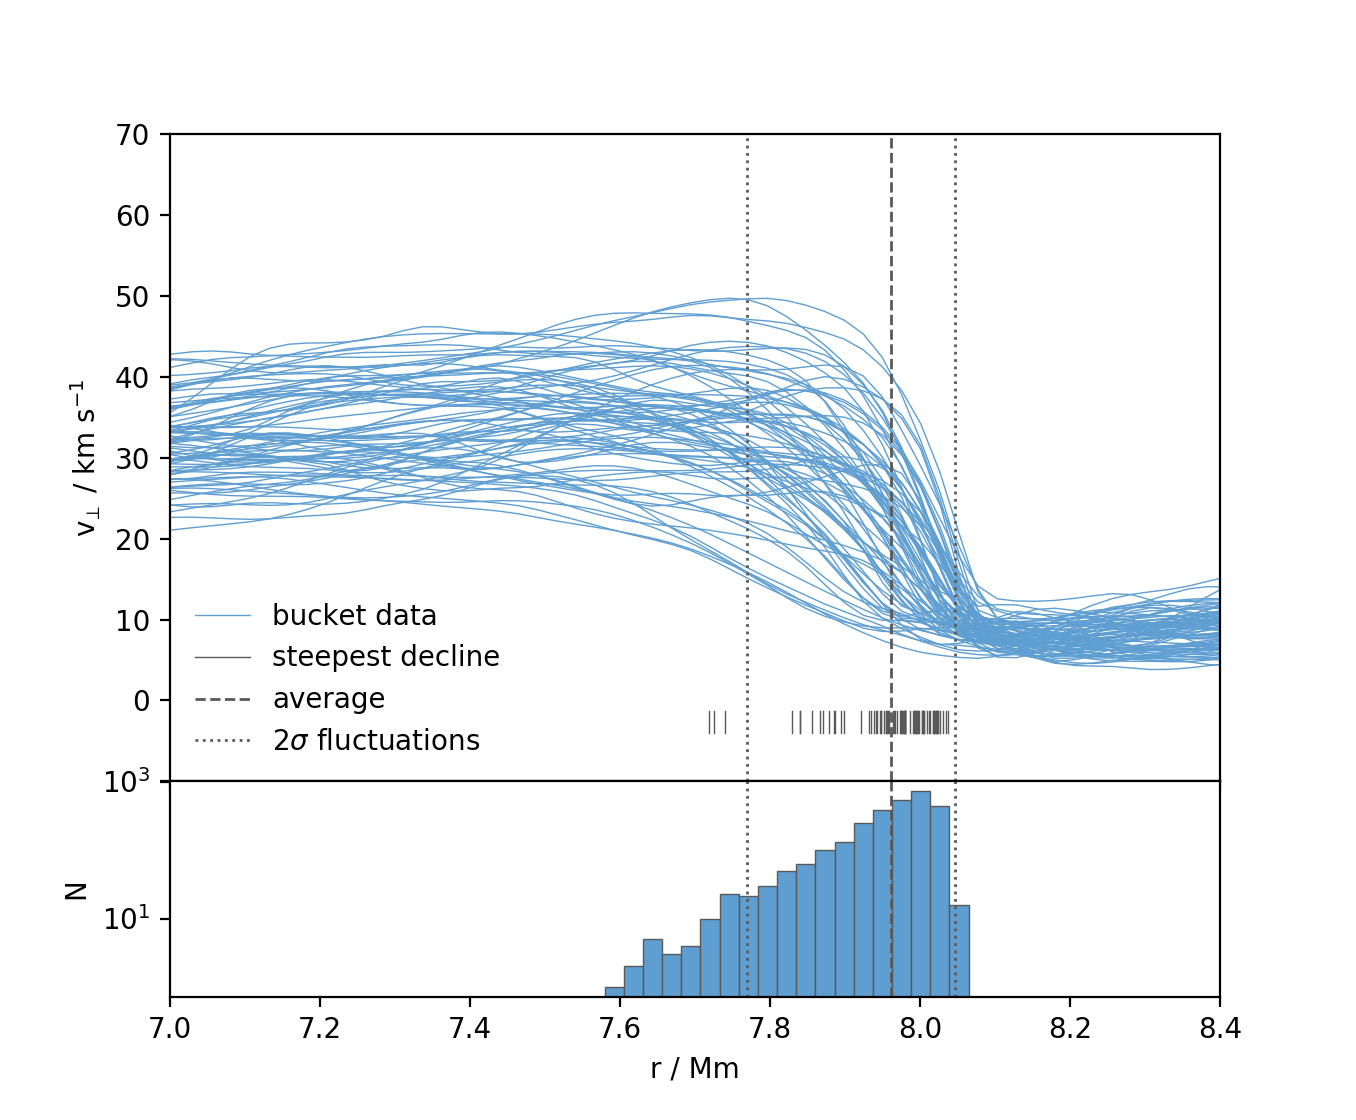

Dump 121 (t = 17.90 min).
Histogram constructed using dumps 101 (t = 14.94 min) to 135 (t = 19.97 min) inclusive.


<IPython.core.display.Javascript object>


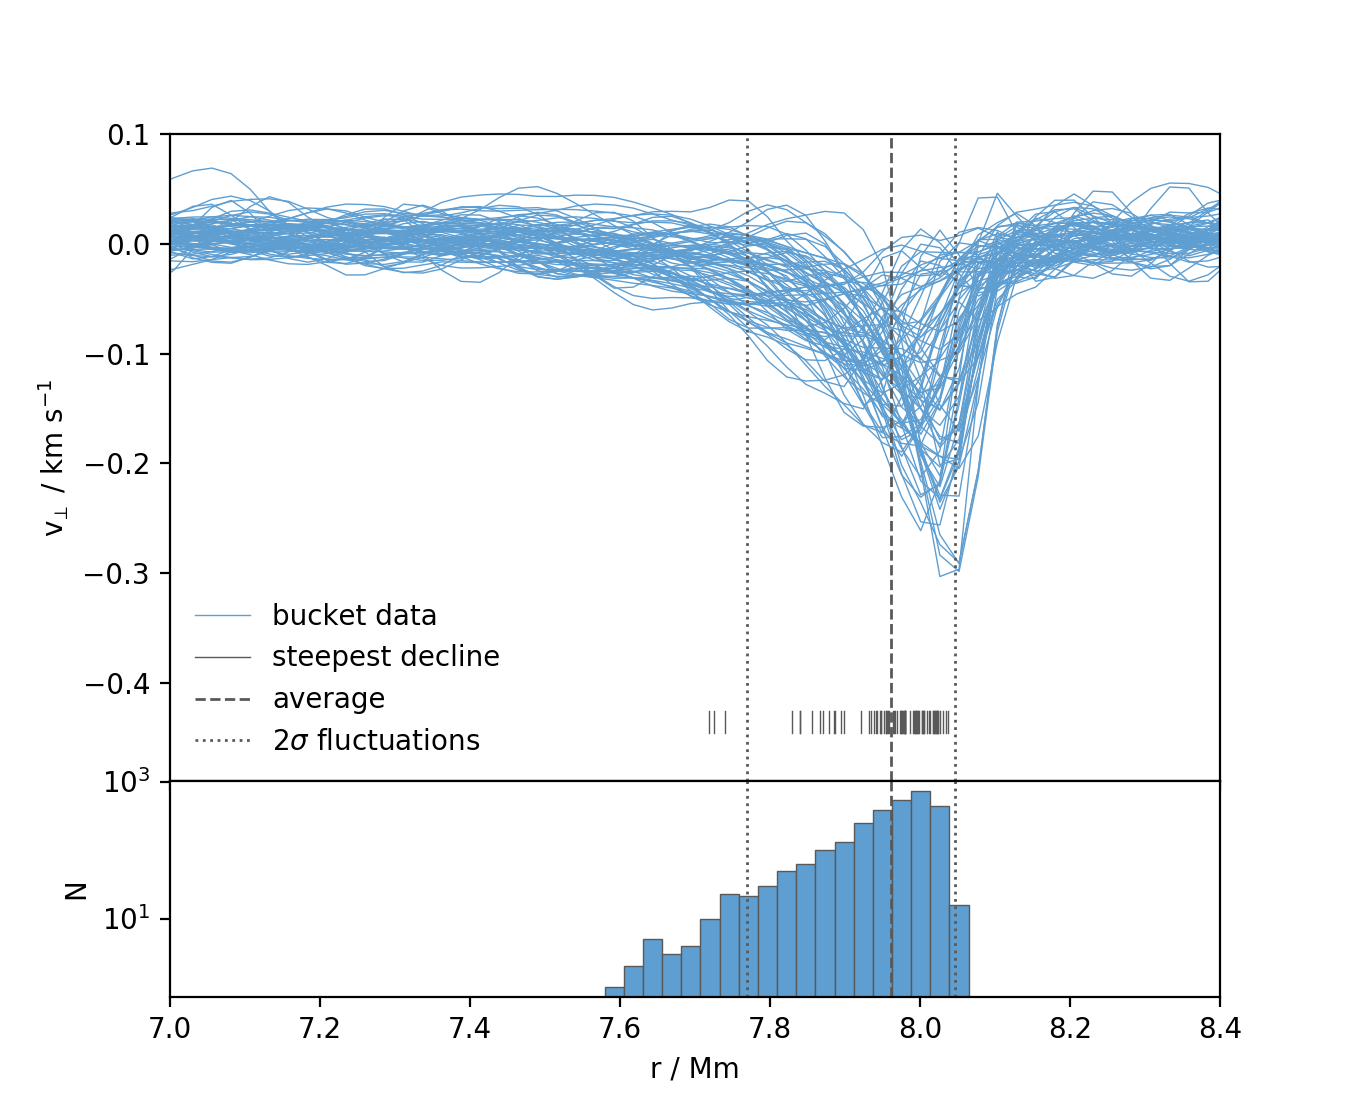

In [82]:
data_path = "/data/ppm_rpod2/RProfiles/O-shell-M25/D15/"
dump_to_plot = 121
hist_dump_min = 101
hist_dump_max = 135
r1 = 7.4
r2 = 8.4

upper_bound_ut(data_path, False, dump_to_plot, hist_dump_min, hist_dump_max, r1, r2)
upper_bound_ut(data_path, True, dump_to_plot, hist_dump_min, hist_dump_max, r1, r2)

## Temporal evolution of the boundary

In [84]:
def plot_boundary_evolution(data_path, show_fits, r1, r2, t_fit_start):
    
    '''

    Displays the time evolution of the convective boundary

    Plots Fig. 14 or 15 in paper: "Idealized hydrodynamic simulations
    of turbulent oxygen-burning shell convection in 4 geometry"
    by Jones, S.; Andrassy, R.; Sandalski, S.; Davis, A.; Woodward, P.; Herwig, F.
    NASA ADS: http://adsabs.harvard.edu/abs/2017MNRAS.465.2991J

    Parameters
    ----------
    data_path = string
        data path
    show_fits = boolean
        show the fits used in finding the upper boundary
    r1/r2 = float
        This function will only search for the convective 
        boundary in the range between r1/r2
    t_fit_start = int
        The time to start the fit for upper boundary fit takes 
        range t[t_fit_start:-1] and computes average boundary
    '''

    rp_set = rprofile.rprofile_set(data_path)
    rp = rp_set.get_dump(dump_to_plot)

    n_dumps = len(rp_set.dumps)
    n_buckets = rp_set.get_dump(rp_set.dumps[0]).get('nbuckets')
    t = np.zeros(n_dumps)
    r_ub = np.zeros((n_buckets, n_dumps))
    avg_r_ub, sigmam_r_ub, sigmap_r_ub, r_ub, t = get_upper_bound(data_path, r1, r2)
    
    idx_fit_start = np.argmin(np.abs(t - t_fit_start))
    t_fit_start = t[idx_fit_start]

    # fc = fit coefficients
    fc_avg = np.polyfit(t[idx_fit_start:-1], avg_r_ub[idx_fit_start:-1], 1)
    avg_fit = fc_avg[0]*t + fc_avg[1]
    fc_plus = np.polyfit(t[idx_fit_start:-1], 2.*sigmap_r_ub[idx_fit_start:-1], 1)
    plus_fit = fc_plus[0]*t + fc_plus[1]
    fc_minus = np.polyfit(t[idx_fit_start:-1], 2.*sigmam_r_ub[idx_fit_start:-1], 1)
    minus_fit = fc_minus[0]*t + fc_minus[1]

    show_fits = False

    ifig = 5; plt.close(ifig); fig = plt.figure(ifig)#, figsize = (6.0, 4.7))
    for bucket in range(n_buckets):
        lbl = 'bucket data' if bucket == 0 else None
        plt.plot(t/60., r_ub[bucket, :], ls = '-', lw = 0.5, color = cb(3), \
                 label = lbl)
    plt.plot(t/60., avg_r_ub, ls = '-', lw = 1., color = cb(4),\
             label = 'mean')
    plt.plot(t/60., avg_r_ub + 2*sigmap_r_ub, ls = '--', lw = 1., \
             color = cb(4), label = r'2$\sigma$ fluctuations')
    plt.plot(t/60., avg_r_ub - 2*sigmam_r_ub, ls = '--', lw = 1., \
             color = cb(4))
    if show_fits:
        plt.plot(t/60., avg_fit, ls = '-', lw = 0.5, color = cb(4), \
                label = r'$\mathregular{linear\ fits}$')
        plt.plot(t/60., avg_fit + plus_fit, ls = '-', lw = 0.5, color = cb(4))
        plt.plot(t/60., avg_fit - minus_fit, ls = '-', lw = 0.5, color = cb(4))
    plt.xlim((0., np.max(t)/60.))
    #plt.ylim((7.4, 8.6))
    plt.xlabel('t / min')
    plt.ylabel(r'r$_\mathrm{ub}$ / Mm')
    plt.legend(loc = 0, frameon = False)
    #fig.tight_layout()
    plt.savefig('D15_r_ub_evolution.pdf')

    print 'The fitting starts at t = {:.1f} s = {:.1f} min.'.format(t_fit_start, t_fit_start/60.)
    print ''
    print 'Average:'
    print '{:.3e} Mm + ({:.3e} Mm/s)*t'.format(fc_avg[1], fc_avg[0])
    print ''
    print 'Positive fluctuations:'
    print '{:.3e} Mm + ({:.3e} Mm/s)*t'.format(fc_plus[1], fc_plus[0])
    print ''
    print 'Negative fluctuations:'
    print '{:.3e} Mm + ({:.3e} Mm/s)*t'.format(fc_minus[1], fc_minus[0])

<IPython.core.display.Javascript object>


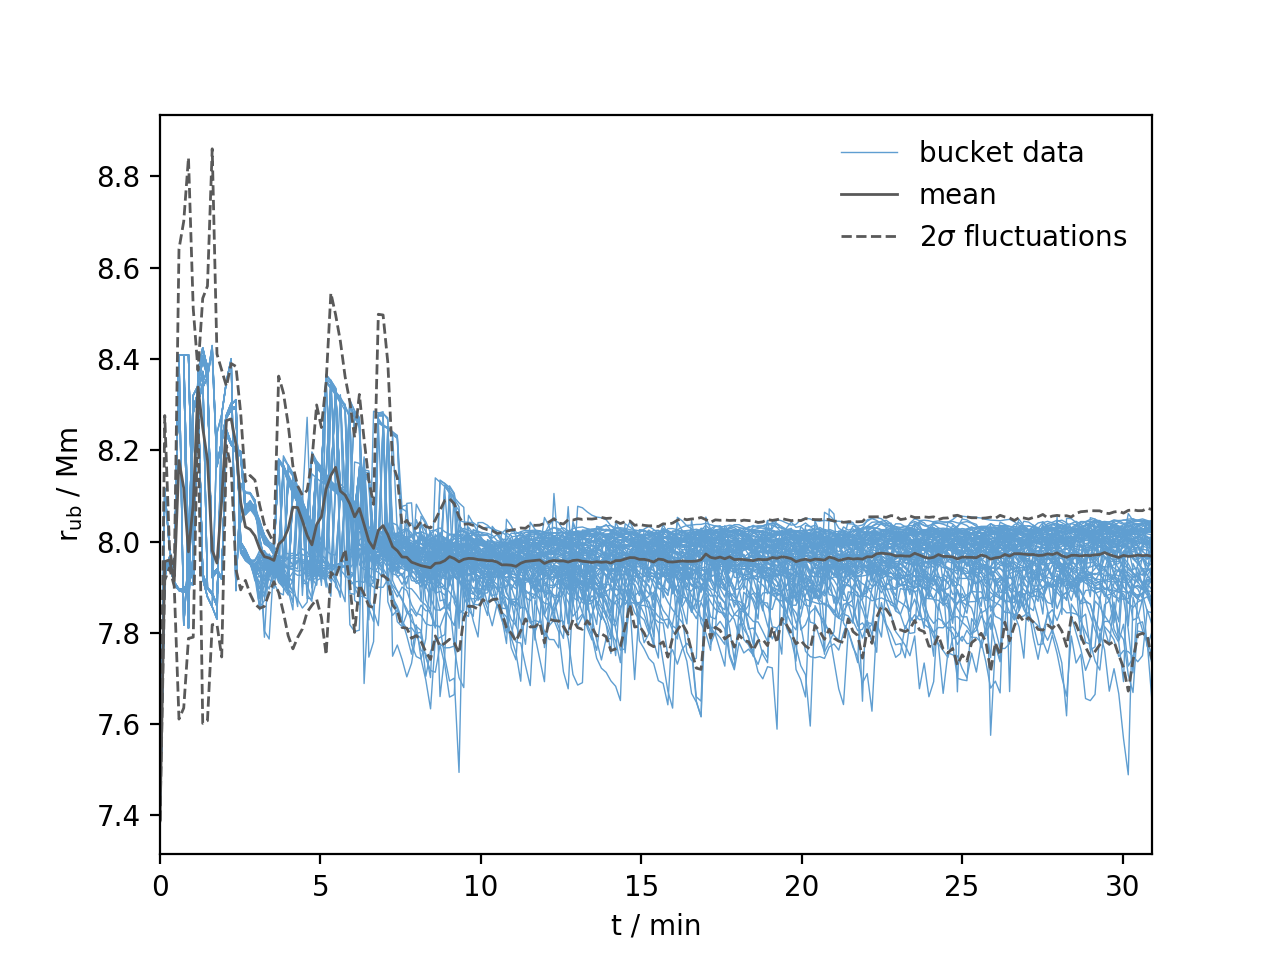

The fitting starts at t = 701.2 s = 11.7 min.

Average:
7.947e+00 Mm + (1.371e-05 Mm/s)*t

Positive fluctuations:
7.945e-02 Mm + (5.321e-06 Mm/s)*t

Negative fluctuations:
1.312e-01 Mm + (3.251e-05 Mm/s)*t


In [85]:
data_path = "/data/ppm_rpod2/RProfiles/O-shell-M25/D15/"
dump_to_plot = 121
hist_dump_min = 101
hist_dump_max = 135
r1 = 7.4
r2 = 8.4
t_fit_start = 700

plot_boundary_evolution(data_path, show_fits, r1, r2,t_fit_start)

## Boundary shape for one dump

Dump 121 (t = 17.90 min).


<IPython.core.display.Javascript object>


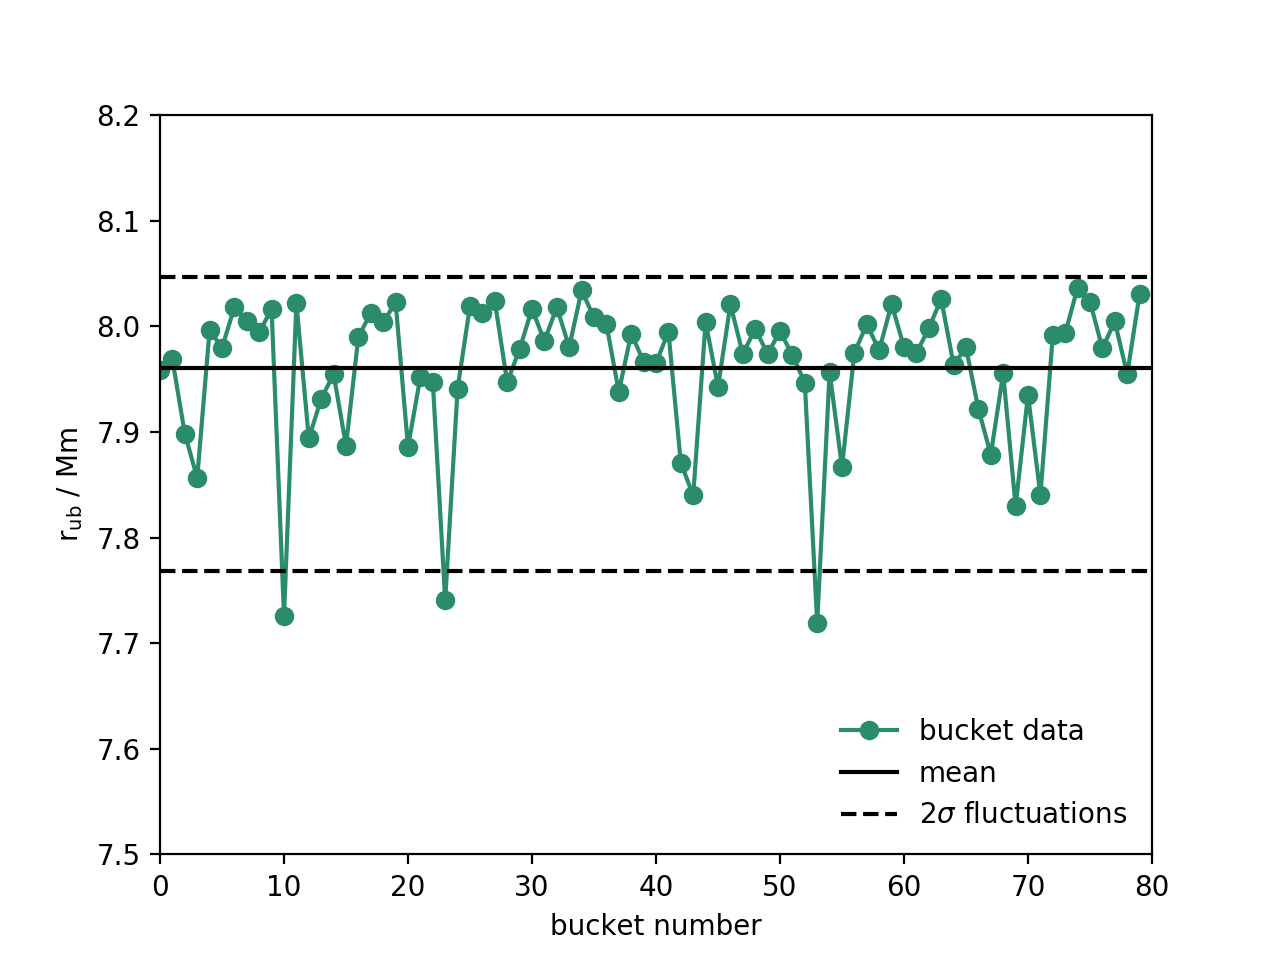

Dump 121 (t = 17.90 min).


<IPython.core.display.Javascript object>


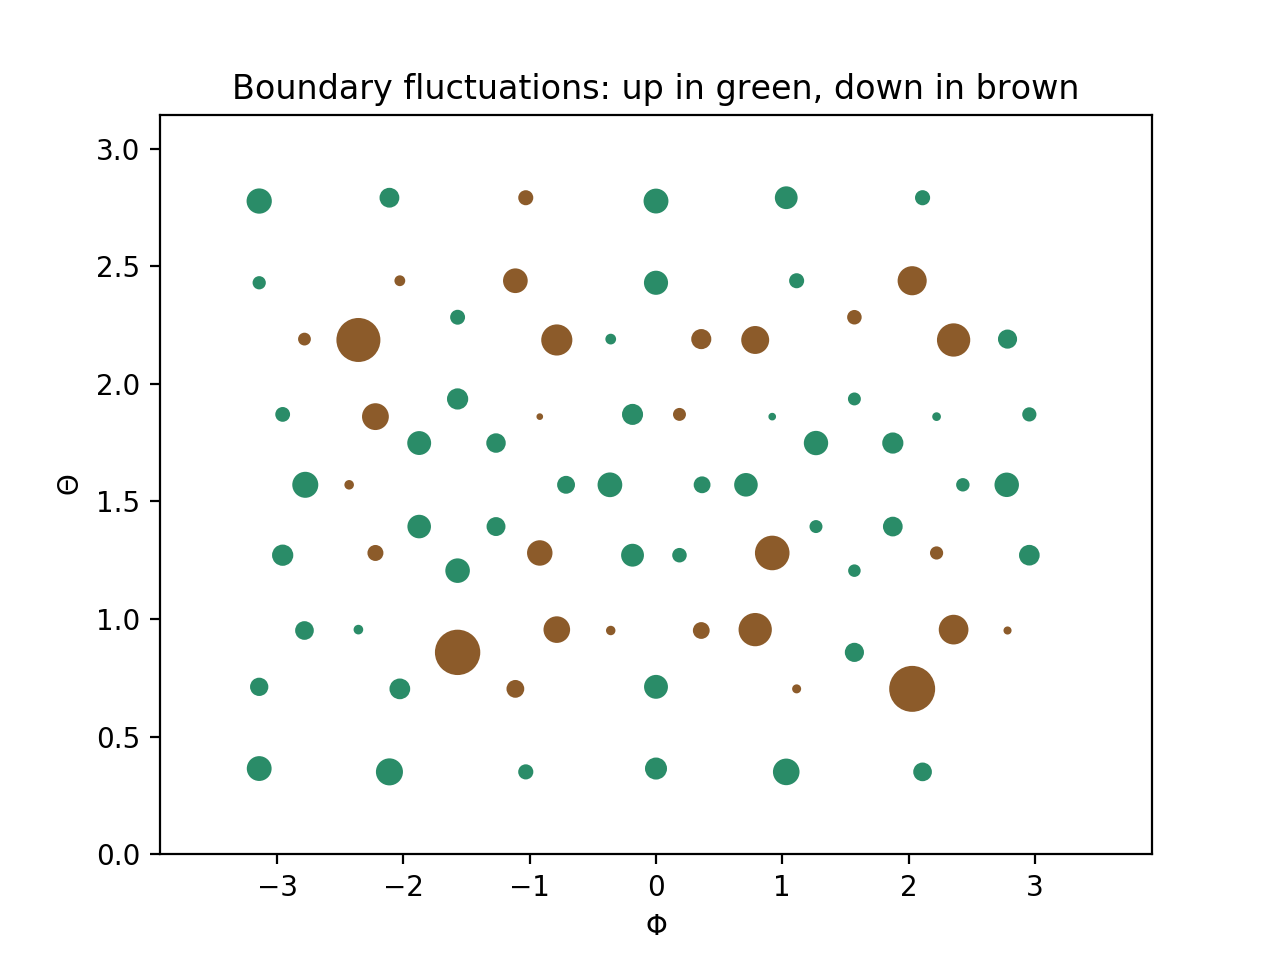

In [22]:
dump_to_plot = 121

print "Dump {:d} (t = {:.2f} min).".format(dump_to_plot, t[dump_to_plot]/60.)
ifig = 3; plt.close(ifig); plt.figure(ifig)
plt.plot(r_ub[:, dump_to_plot], ls = '-', lw = 1.5, marker = 'o', color = '#2a8c68', \
         label = r'bucket data')
tmp = avg_r_ub[dump_to_plot]
plt.plot((0, n_buckets), (tmp, tmp), ls = '-', lw = 1.5, color = 'k', \
         label = r'mean')
tmp = avg_r_ub[dump_to_plot] + 2*sigmap_r_ub[dump_to_plot]
plt.plot((0, n_buckets), (tmp, tmp), ls = '--', lw = 1.5, color = 'k', \
         label = r'2$\sigma$ fluctuations')
tmp = avg_r_ub[dump_to_plot] - 2*sigmam_r_ub[dump_to_plot]
plt.plot((0, n_buckets), (tmp, tmp), ls = '--', lw = 1.5, color = 'k')
plt.xlim((0, n_buckets))
plt.ylim((7.5, 8.2))
plt.xlabel(r'bucket number')
plt.ylabel(r'r$_\mathrm{ub}$ / Mm')
plt.legend(loc = 4, frameon = False)

print "Dump {:d} (t = {:.2f} min).".format(dump_to_plot, t[dump_to_plot]/60.)
ifig = 4; plt.close(ifig); fig = plt.figure(ifig)
ax = fig.add_subplot(111)
centers = rp_set.get_dump(dump_to_plot).get_centers()
x = centers[0, :]
y = centers[1, :]
z = centers[2, :]
r = (x**2 + y**2 + z**2)**0.5
phi = np.arctan2(y, x)
theta = np.arccos(z/r)
diff = r_ub[:, dump_to_plot] - avg_r_ub[dump_to_plot]
marker_area = 1e3*np.abs(diff)
marker_color = [('#2a8c68' if this_diff >= 0 else '#8c5b2a') for this_diff in diff]
ax.scatter(phi, theta, s = marker_area, marker = 'o', color = marker_color)
ax.set_xlim((-1.25*np.pi, 1.25*np.pi))
ax.set_ylim((0., np.pi))
ax.set_xlabel(r'$\Phi$')
ax.set_ylabel(r'$\Theta$')
ax.set_title("Boundary fluctuations: up in green, down in brown")